In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Reshape, MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical


In [3]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("No TPU found. Using default strategy.")
    strategy = tf.distribute.get_strategy()

No TPU found. Using default strategy.


In [50]:
import os
import random

paths = []
labels = []

# Define the root directories
real_root_dir = 'C:/Users/Asus/Desktop/Audio Detection/Audio-DeepFake-Detection-using-CNN-BiLSTM/data/real'
fake_root_dir = 'C:/Users/Asus/Desktop/Audio Detection/Audio-DeepFake-Detection-using-CNN-BiLSTM/data/fake/ljspeech_melgan'

# Define the number of samples to select from each directory
num_samples = 1000 # Adjust this number as needed

# Function to sample files from a directory
def sample_files(directory, label, num_samples):
    files = os.listdir(directory)
    sampled_files = random.sample(files, min(num_samples, len(files)))
    for filename in sampled_files:
        file_path = os.path.join(directory, filename)
        paths.append(file_path)
        labels.append(label)

# Sample files from the real and fake directories
sample_files(real_root_dir, 'real', num_samples)
sample_files(fake_root_dir, 'fake', num_samples)

print('Dataset is loaded')

# Create a DataFrame from the sampled paths and labels
df_sample = pd.DataFrame({
    'file_path': paths,
    'label': labels
})

print(df_sample.head())

# Function to extract features from audio files


Dataset is loaded
                                           file_path label
0  C:/Users/Asus/Desktop/Audio Detection/Audio-De...  real
1  C:/Users/Asus/Desktop/Audio Detection/Audio-De...  real
2  C:/Users/Asus/Desktop/Audio Detection/Audio-De...  real
3  C:/Users/Asus/Desktop/Audio Detection/Audio-De...  real
4  C:/Users/Asus/Desktop/Audio Detection/Audio-De...  real


In [51]:
print(len(paths))

2000


In [52]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels


In [28]:
df_sample = df.sample(frac=0.2,random_state=42)  # Selects 10% of the data randomly


In [29]:
len(df_sample)

5240

In [30]:
df_sample['label'].value_counts()


label
real    2654
fake    2586
Name: count, dtype: int64

**Visualization of Audio and Features**

In [53]:
real_audio = 'C:/Users/Asus/Desktop/Audio Detection/Audio-DeepFake-Detection-using-CNN-BiLSTM/data/real/LJ001-0001.wav'
fake_audio = 'C:/Users/Asus/Desktop/Audio Detection/Audio-DeepFake-Detection-using-CNN-BiLSTM/data/fake/ljspeech_melgan/LJ001-0001_gen.wav'

In [32]:
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [33]:
import IPython

fake_audio = 'C:/Users/Asus/Desktop/Audio Detection/Audio-DeepFake-Detection-using-CNN-BiLSTM/data/fake/ljspeech_melgan/LJ001-0001_gen.wav'

print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


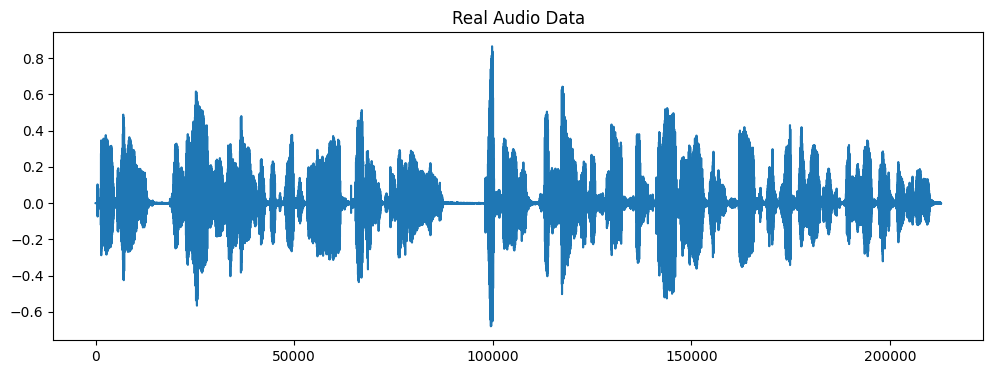

In [34]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

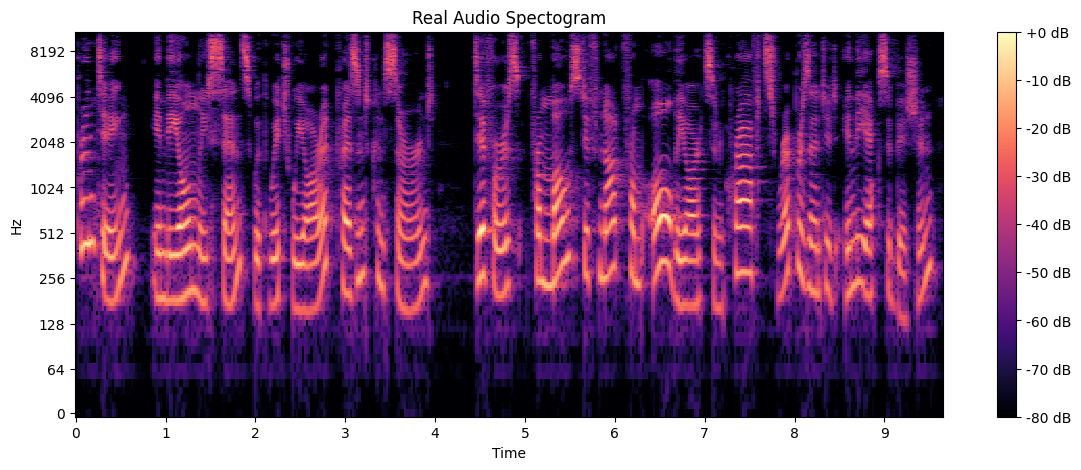

In [35]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

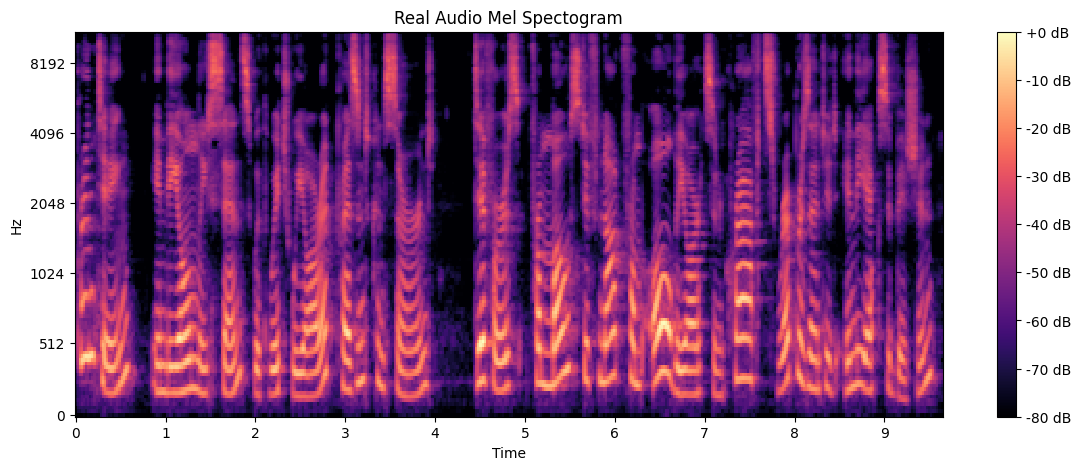

In [36]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

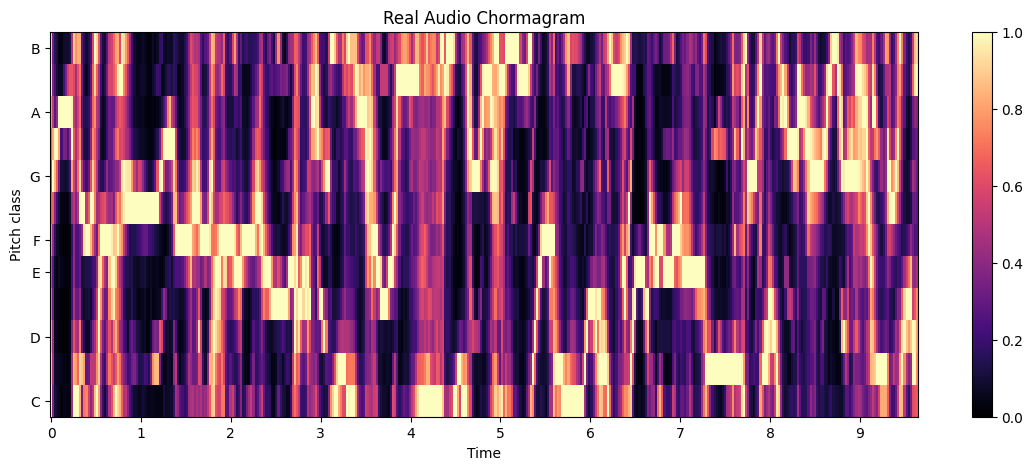

In [37]:
real_chroma = librosa.feature.chroma_cqt(y = real_ad, sr = real_sr, bins_per_octave=36)
plt.figure(figsize = (14, 5))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

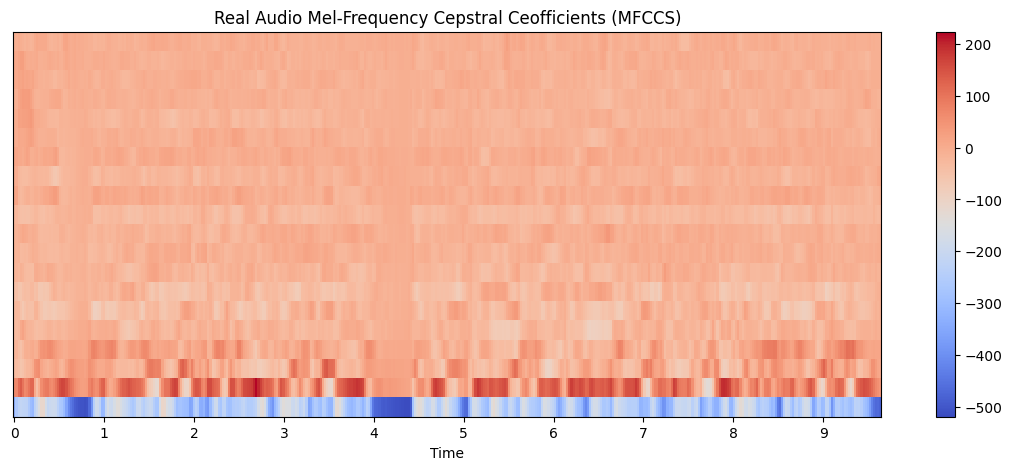

In [38]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mfcc, sr = real_sr, x_axis ='time')
plt.colorbar()
plt.title('Real Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

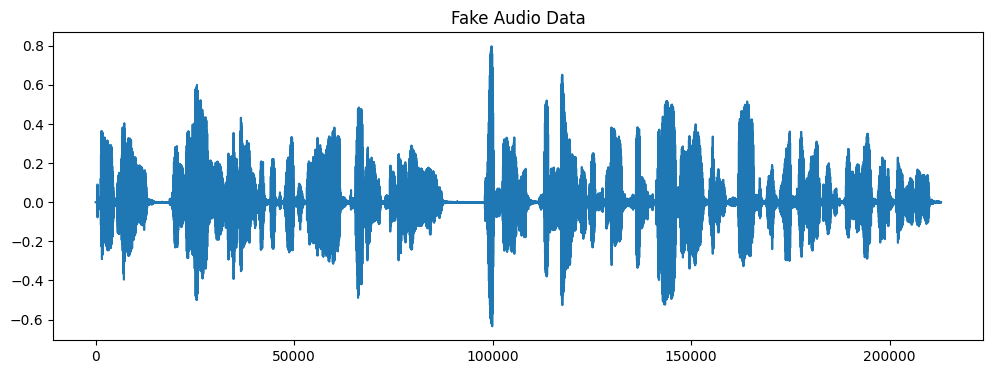

In [39]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize =(12,4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

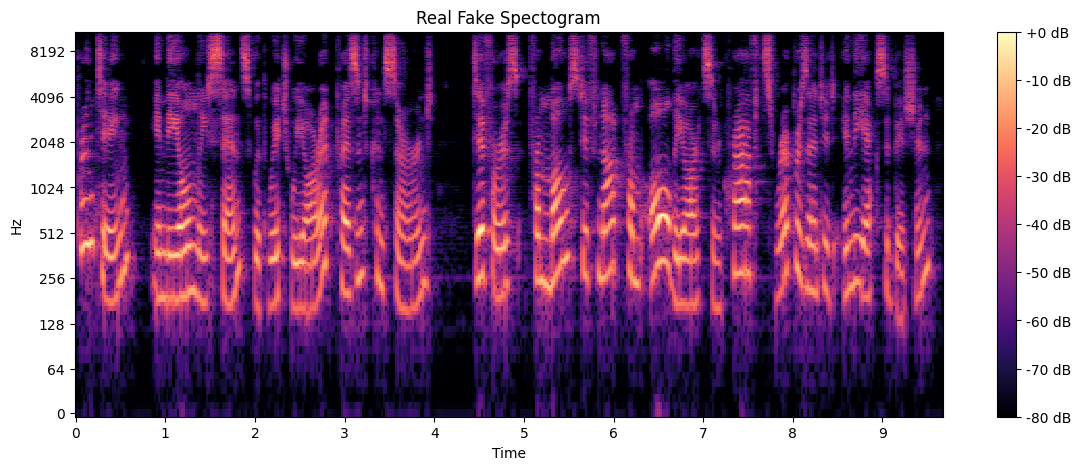

In [40]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Fake Spectogram")
plt.show()

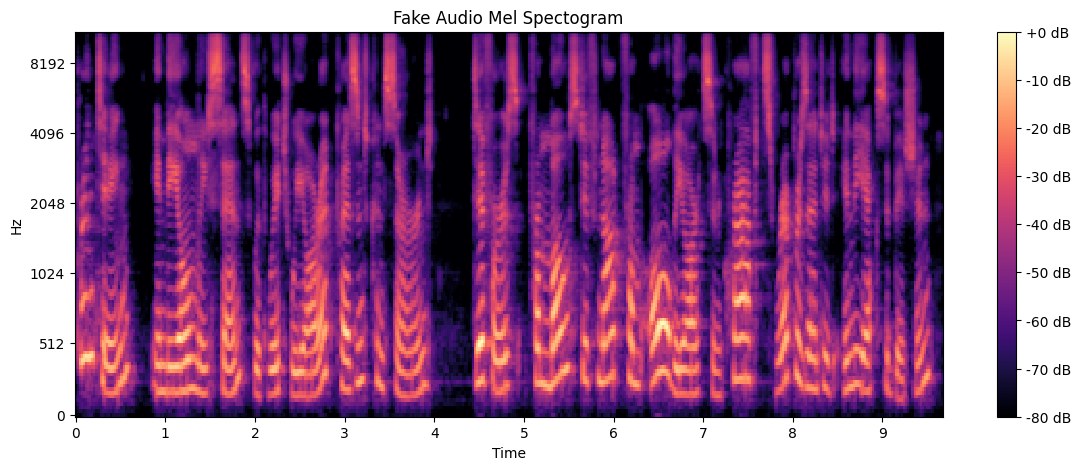

In [41]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()


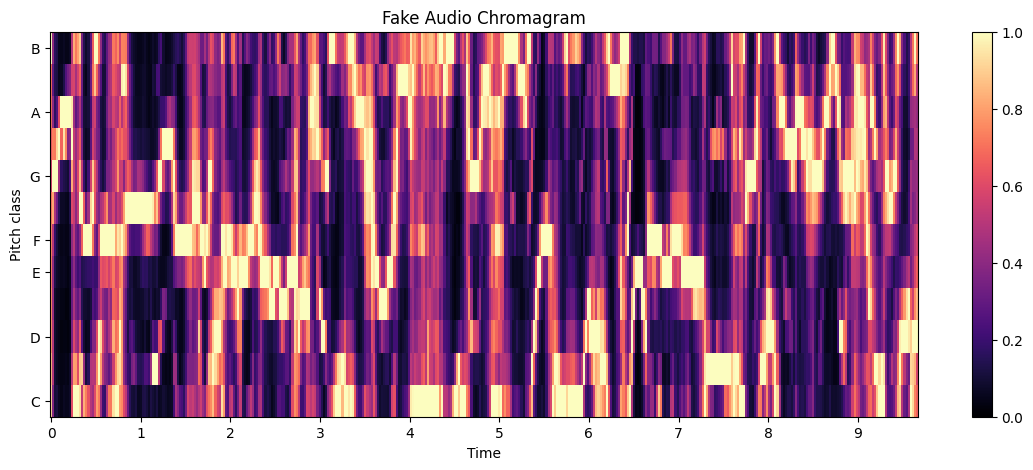

In [42]:
fake_chroma = librosa.feature.chroma_cqt(y = fake_ad, sr = fake_sr, bins_per_octave=36)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_chroma, sr = fake_sr, x_axis= 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Fake Audio Chromagram')
plt.show()

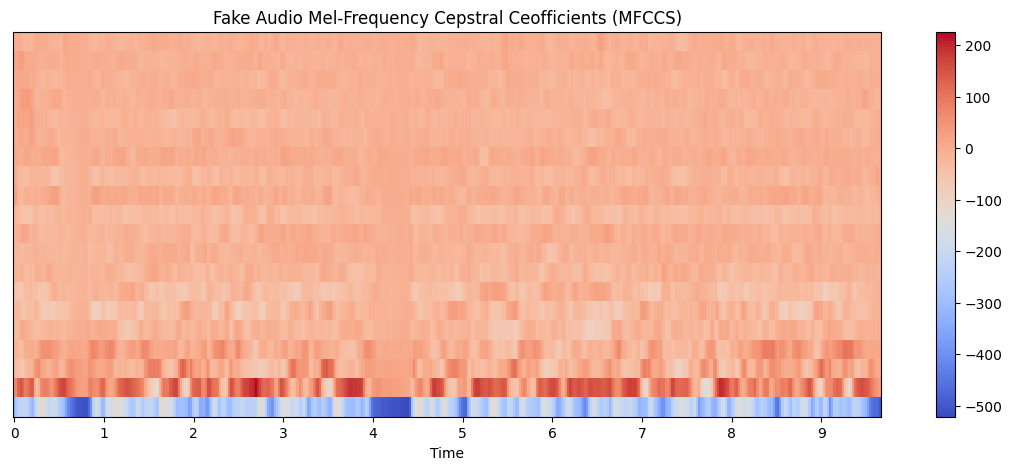

In [43]:
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mfcc, sr = fake_sr, x_axis ='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

In [55]:
def extract_features(df_sample, max_length=500):
    features = []
    labels = []
    
    for index, row in df_sample.iterrows():
        file_path = row['file_path']
        label = row['label']
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            # Assign label
            labels.append(1 if label == 'fake' else 0)
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
            
    return np.array(features), np.array(labels)

x, y = extract_features(df_sample)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

Features shape: (2000, 40, 500)
Labels shape: (2000,)


In [56]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

**Model Architecture**

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
with strategy.scope():
    # Create and compile the model inside the strategy scope
    model = Sequential([
        layers.Reshape((40, 500, 1), input_shape=xtrain.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    

# Print the model summary to confirm the structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 40, 500, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 500, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 40, 500, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 250, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 250, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 125, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 62, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 310, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 310, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 310, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,049 (3.00 MB)

 Trainable params: 784,577 (2.99 MB)

 Non-trainable params: 1,472 (5.75 KB)

***Training***

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation accuracy instead of loss
    patience=10,                     # Stop after 10 epochs of no improvement
    restore_best_weights=True,      # Restore the weights from the epoch with the best validation accuracy
    mode='max',                     # 'max' because higher accuracy is better (we want to maximize val_accuracy)
    verbose=1                       # Output when training stops early
)

# Train the model with early stopping
history = model.fit(
    xtrain, ytrain,                 # Training data
    epochs=10,        # Max number of epochs
    batch_size=32,                  # Batch size
    validation_data=(xtest, ytest),   # Validation data
    callbacks=[early_stopping]      # Add early stopping callback
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.5373 - loss: 0.8397 - val_accuracy: 0.5075 - val_loss: 0.8212
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.5596 - loss: 0.8193 - val_accuracy: 0.7275 - val_loss: 0.7277
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.5506 - loss: 0.8256 - val_accuracy: 0.7050 - val_loss: 0.7352
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.6441 - loss: 0.7638 - val_accuracy: 0.5800 - val_loss: 0.8052
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.5990 - loss: 0.7815 - val_accuracy: 0.7650 - val_loss: 0.6278
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.7020 - loss: 0.6978 - val_accuracy: 0.6075 - val_loss: 0.7565
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.7046 - loss: 0.6623 - val_accuracy: 0.6425 - val_loss: 0.8771
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.7797 - loss: 0.5867 - val_accuracy: 0.8575 - v

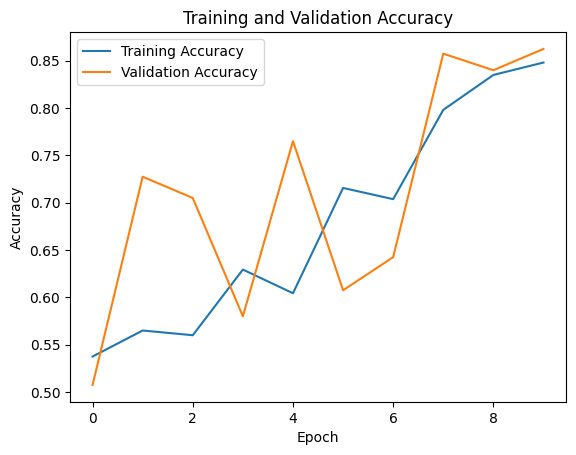

In [62]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [63]:
loss,accuracy = model.evaluate(xtest,ytest)

13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8629 - loss: 0.4750


In [ ]:
# Create a CPU model with the same architecture
cpu_model = tf.keras.models.clone_model(model)

# Copy weights from TPU model to CPU model
cpu_model.set_weights(model.weights)

# Save the CPU model
cpu_model.save('my_model.h5')

In [66]:
cpu_model.save('my_model.keras')